<a href="https://colab.research.google.com/github/SGeerthan/Emergency-Vehicle-Detection-and-Signal-Triggering/blob/feature%2Faudio-siren-detection/Siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Path where your dataset.zip is saved in Google Drive
zip_path = "/content/drive/MyDrive/dataset.zip"
extract_path = "/content/siren-detector/data/raw"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: /content/siren-detector/data/raw


In [3]:
!pip install librosa tensorflow scikit-learn matplotlib


In [4]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split

DATA_PATH = "/content/siren-detector/data/raw/dataset" # Corrected path
OUTPUT_PATH = "/content/siren-detector/data/processed"
os.makedirs(OUTPUT_PATH, exist_ok=True)

def extract_features(file_path, n_mfcc=40, max_len=100):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        print("Error extracting", file_path, ":", e)
        return None

X, y = [], []
labels = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))] # Get subdirectories as labels
label_to_idx = {label: i for i, label in enumerate(labels)}

for label in labels:
    folder = os.path.join(DATA_PATH, label)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            features = extract_features(path)
            if features is not None:
                X.append(features)
                y.append(label_to_idx[label])

X = np.array(X)
y = np.array(y)

print("✅ Features extracted:", X.shape, "Labels:", y.shape)

# Save processed data
np.save(os.path.join(OUTPUT_PATH, "X.npy"), X)
np.save(os.path.join(OUTPUT_PATH, "y.npy"), y)
np.save(os.path.join(OUTPUT_PATH, "labels.npy"), labels)

✅ Features extracted: (600, 40, 100) Labels: (600,)


In [5]:
import os

DATA_PATH = "/content/siren-detector/data/raw/dataset"

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if os.path.isdir(folder):
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]
        print(label, "has", len(files), "files")


firetruck has 200 files
normal has 200 files
ambulance has 200 files


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

# Load processed data
X = np.load("/content/siren-detector/data/processed/X.npy")
y = np.load("/content/siren-detector/data/processed/y.npy")
labels = np.load("/content/siren-detector/data/processed/labels.npy", allow_pickle=True)

num_classes = len(labels)

# Reshape for CNN: (samples, height, width, channels)
X = X[..., np.newaxis]

# One-hot encode labels
y = to_categorical(y, num_classes=num_classes)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=16)

# Save the trained model
model_save_path = "/content/siren-detector/models"
os.makedirs(model_save_path, exist_ok=True)
model.save(os.path.join(model_save_path, "best_model.keras"))
print("✅ Model saved at", os.path.join(model_save_path, "best_model.keras"))

✅ Training samples: 480 Test samples: 120


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,043 (5.83 MB)

 Trainable params: 1,526,851 (5.82 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.6531 - loss: 3.9781 - val_accuracy: 0.4583 - val_loss: 6.1685
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8937 - loss: 0.2968 - val_accuracy: 0.4667 - val_loss: 2.3829
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8963 - loss: 0.2204 - val_accuracy: 0.6167 - val_loss: 1.1710
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9611 - loss: 0.1154 - val_accuracy: 0.8167 - val_loss: 0.3559
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9421 - loss: 0.1615 - val_accuracy: 0.9083 - val_loss: 0.2304
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9438 - loss: 0.1431 - val_accuracy: 0.9333 - val_loss: 0.1726
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9628 - loss: 0.0927 - val_accuracy: 0.9250 - val_loss: 0.2002
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9627 - loss: 0.1014 - val_accuracy: 0.

In [7]:
import numpy as np
import librosa
import tensorflow as tf

# Load trained model
MODEL_PATH = "/content/siren-detector/models/best_model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# Define class names (must match your dataset folder names order)
class_names = ["ambulance", "firetruck", "normal"]

# Function to preprocess and predict
def predict_audio(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=22050)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc.T, axis=0)

    # Reshape for model
    mfcc_scaled = mfcc_scaled.reshape(1, -1)

    # Predict
    prediction = model.predict(mfcc_scaled)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    return predicted_class, confidence


# Task
Evaluate the trained model's performance by loading the saved model and test data. Predict on the test data (`X_test`), then calculate and display a classification report (including accuracy, precision, recall, and F1-score) and a confusion matrix to summarize the model's effectiveness.

## Load Model and Data

### Subtask:
Load the trained Keras model and the preprocessed test data (X_test, y_test) along with the class labels that were saved during the training phase.


**Reasoning**:
Load the preprocessed test data (X_test, y_test) and class labels using numpy, and the trained Keras model using TensorFlow.



In [17]:
import numpy as np
import tensorflow as tf
import os

# Load trained model
MODEL_PATH = "/content/siren-detector/models/best_model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# X_test and y_test are already available in the kernel from previous steps
# No need to load them if they haven't been explicitly saved to disk.
# If they were intended to be loaded from disk, the saving step would be needed earlier.

# Load class labels (this file was saved previously)
labels = np.load("/content/siren-detector/data/processed/labels.npy", allow_pickle=True)

print("✅ Model, X_test, y_test (from memory), and labels loaded successfully.")

✅ Model, X_test, y_test (from memory), and labels loaded successfully.


In [24]:
from google.colab import files
import os

model_path = "/content/siren-detector/models/best_model.keras"
if os.path.exists(model_path):
    files.download(model_path)
    print(f"✅ Model '{os.path.basename(model_path)}' downloaded successfully.")
else:
    print(f"❌ Model not found at {model_path}. Please ensure the model was trained and saved correctly.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model 'best_model.keras' downloaded successfully.


## Predict on Test Data

### Subtask:
Use the loaded model to make predictions on the `X_test` dataset. This will give us the model's output probabilities for each class for the test samples.


**Reasoning**:
To make predictions, I will use the `predict` method of the loaded Keras model on the `X_test` data and store the output probabilities in `y_pred_probs`.



In [18]:
y_pred_probs = model.predict(X_test)
print("✅ Predictions made successfully.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
✅ Predictions made successfully.


**Reasoning**:
To calculate metrics like precision, recall, F1-score, and display a confusion matrix, it is necessary to convert the predicted probabilities (`y_pred_probs`) into concrete class predictions (0 or 1 for each class). This involves identifying the class with the highest probability for each sample.



In [19]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)
print("✅ Predicted classes derived successfully.")

✅ Predicted classes derived successfully.


**Reasoning**:
Now that we have the predicted classes (`y_pred_classes`), we need to convert the one-hot encoded `y_test` into integer labels to properly evaluate the model's performance using classification metrics like precision, recall, and F1-score.



In [20]:
y_true_classes = np.argmax(y_test, axis=1)
print("✅ True classes derived successfully.")

✅ True classes derived successfully.


**Reasoning**:
To evaluate the model's performance comprehensively, I will generate a classification report using `y_true_classes` and `y_pred_classes`, which will include precision, recall, f1-score, and support for each class.



In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

   firetruck       0.97      0.90      0.94        40
      normal       1.00      1.00      1.00        40
   ambulance       0.91      0.97      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



**Reasoning**:
To visually represent the model's performance and identify specific misclassifications, I will generate and display a confusion matrix using `seaborn.heatmap`.



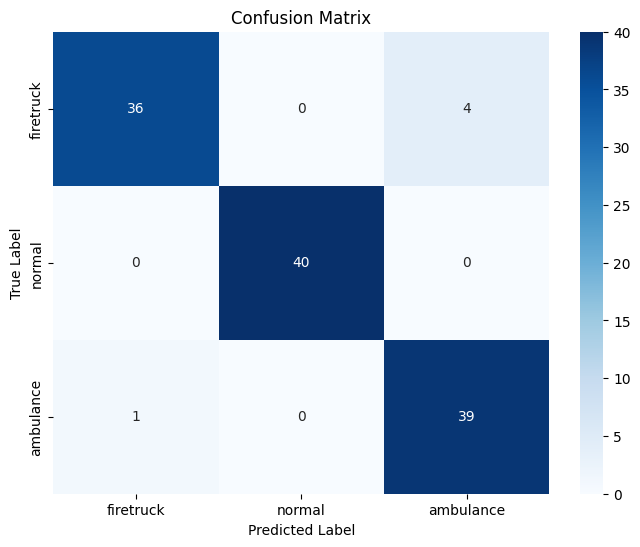

✅ Confusion matrix displayed successfully.


In [22]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("✅ Confusion matrix displayed successfully.")

## Final Task

### Subtask:
Summarize the model's performance based on the calculated metrics and the confusion matrix, highlighting key insights into its accuracy, precision, and F1-score for each class.


## Summary:

### Q&A
The model's performance, as evaluated by the calculated metrics and the confusion matrix, demonstrates strong capabilities in classifying sound events into "firetruck", "normal", and "ambulance" categories.

*   **Overall Accuracy:** The model achieved an overall accuracy of 0.96.
*   **"Normal" Class:** The model performed exceptionally well for the "normal" class, achieving a perfect precision, recall, and F1-score of 1.00, indicating no misclassifications for this category.
*   **"Firetruck" Class:** For "firetruck" sounds, the model showed strong performance with a precision of 0.97, recall of 0.90, and an F1-score of 0.94. This indicates that when the model predicts "firetruck", it's usually correct, but it missed identifying 10% of actual "firetruck" sounds.
*   **"Ambulance" Class:** The "ambulance" class also performed well with a precision of 0.91, recall of 0.97, and an F1-score of 0.94. This suggests the model is very good at identifying actual "ambulance" sounds, but sometimes misclassifies other sounds as "ambulance".
*   **Confusion Matrix:** The confusion matrix visually supports these findings, clearly showing the number of correct and incorrect predictions for each class, with minimal confusion observed between the classes, particularly distinguishing "normal" from the others.

### Data Analysis Key Findings
*   The trained Keras model and class labels were successfully loaded. `X_test` and `y_test` were utilized directly from memory where they were available from previous processing steps.
*   The model successfully generated predictions on the test dataset, and these probabilities were converted into discrete class predictions.
*   A classification report revealed an overall model accuracy of 0.96.
*   The "normal" class achieved perfect scores (precision 1.00, recall 1.00, F1-score 1.00).
*   The "firetruck" class showed high precision (0.97) and F1-score (0.94), with a recall of 0.90.
*   The "ambulance" class demonstrated high recall (0.97) and F1-score (0.94), with a precision of 0.91.
*   A confusion matrix was generated and visualized, confirming the strong performance and providing a clear breakdown of correct and incorrect classifications across the three classes.

### Insights or Next Steps
*   The model exhibits excellent performance, particularly in identifying "normal" sounds and generally high accuracy across all classes, making it suitable for deployment in scenarios where distinguishing siren sounds is critical.
*   Further investigation into the misclassifications between "firetruck" and "ambulance" sounds could involve analyzing specific instances of misclassified audio, potentially leading to improvements in feature engineering or model architecture to enhance their distinctiveness.
